In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from natsort import natsorted

In [2]:
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]

In [34]:
# Note: Cosine similarity is defined for the embedding layers whereas ID and NO are defined for the model layers.

all_models = ['Llama-3-8B', 'Mistral-7B', 'Pythia-6.9B']
NCOL = 3 if len(all_models) <= 3 else 2
model_titles = {'Llama-3-8B' : 'Llama-3-8B' , 'Mistral-7B':'Mistral-7B', 'Pythia-6.9B':'Pythia-6.9B', 'Pythia-6.9B-Deduped':'Pythia-6.9B (D)'}
num_prompts, num_layers = 2244, 32
input_dir = '../Pile-Shuffled'
losses = {}
"""
Older version
for model_name in all_models:
    ifiles = f'{input_dir}/{model_name}/losses/*.npy'
    filelst= natsorted(glob.glob(ifiles)) 
    losses[model_name] = np.concatenate([np.load(file) for file in filelst], axis = 0)
    np.save(f'{input_dir}/{model_name}/summaries/losses.npy', losses[model_name])
"""
for model_name in all_models:
    losses[model_name] = np.load(f'{input_dir}/{model_name}/summaries/losses.npy')
    
csn_sims = {}
for model_name in all_models:
    csn_sims[model_name] = np.load(f'{input_dir}/{model_name}/summaries/csn_sim.npy').transpose([0, 2, 1])
    
ids = {}
for model_name in all_models:
    ids[model_name] = np.load(f'{input_dir}/{model_name}/summaries/gride.npy')[:,:, 0, :]
    
mnos = {}
for model_name in all_models:
    mnos[model_name] = np.load(f'{input_dir}/{model_name}/summaries/mnos.npy')
    
# cmp = {'Llama-3-8B': colors6[3], 'Mistral-7B': colors6[4], 'Pythia-6.9B': colors6[0], 'Pythia-6.9B-Deduped': colors6[1]}

cmp = {'Llama-3-8B': colors6[3], 'Mistral-7B': colors6[2], 'Pythia-6.9B': colors6[0]}

TEST_INDX_SHUFFLE = 14 # The test prompt we use throughout the paper to display results for a single prompt.
filtered_indices = np.load('../../filtered_indices.npy')
subset_indices = np.load('../../subset_indices.npy')
TEST_INDX = np.where(filtered_indices == subset_indices[TEST_INDX_SHUFFLE])[0][0] # The test prompt we use throughout the paper to display results for a single prompt.
TEST_INDX

686

## The geometry of shuffled and unshuffled prompts (Section 4.2)

In [18]:
colors = [colors6[0], colors6[3]]
positions = [0, 1]
cmap2 = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

In [19]:
NUM_SHUFFLES = 6

### Cosine similarity

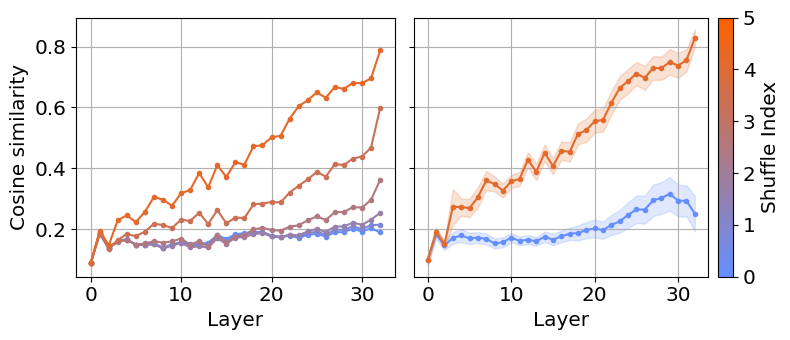

In [23]:
start_ind = 0
end_ind = num_layers + 1
xrange = np.arange(start_ind, end_ind)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey="row")
model_name = "Llama-3-8B"
for jdx in range(2):
    ax = axes[jdx]
    ops = csn_sims[model_name][:, :, 0]
    if jdx == 0: ax.set_ylabel(f"Cosine similarity", fontsize="x-large")
    if jdx == 0:
        for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * TEST_INDX_SHUFFLE, NUM_SHUFFLES * (TEST_INDX_SHUFFLE + 1))):
            ax.plot(xrange, ops[shuffle_idx], marker='.', c=cmap2(qdx/NUM_SHUFFLES))
    else:
        for qdx in [0, 5]:
            op = ops[qdx::6, :]

            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label=model_name, c=cmap2(qdx/NUM_SHUFFLES), marker='.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmap2(qdx/NUM_SHUFFLES), alpha=0.2)

    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

# Create a ScalarMappable object for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=NUM_SHUFFLES-1))
sm.set_array([])

# Add color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Shuffle Index', fontsize='x-large')
cbar.ax.tick_params(labelsize='x-large')

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
plt.savefig(f'figs/shuffle/cosine_llama_{TEST_INDX_SHUFFLE}.png', bbox_inches='tight', dpi=300)
plt.show()

### Intrinsic Dimension

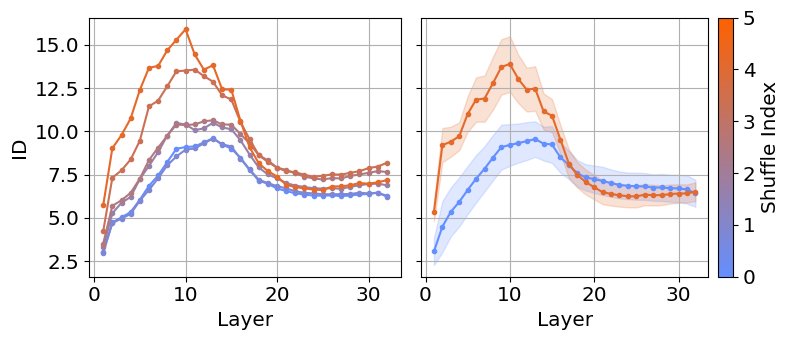

In [25]:
start_ind = 1
end_ind = num_layers + 1
xrange = np.arange(start_ind, end_ind)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey="row")
rs_idx = 0
model_name = "Llama-3-8B"
for jdx in range(2):
    ax = axes[jdx]
    ops = ids[model_name][:, :, rs_idx]
    if jdx == 0: ax.set_ylabel(f"ID", fontsize="x-large")
    if jdx == 0:
        for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * TEST_INDX_SHUFFLE, NUM_SHUFFLES * (TEST_INDX_SHUFFLE + 1))):
            ax.plot(xrange, ops[shuffle_idx], marker='.', c=cmap2(qdx/NUM_SHUFFLES))
    else:
        
        for qdx in [0, 5]:
            op = ops[qdx::6, :]

            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label=model_name, c=cmap2(qdx/NUM_SHUFFLES), marker='.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(np.arange(start_ind, end_ind), mean_op - std_op, mean_op + std_op, color=cmap2(qdx/NUM_SHUFFLES), alpha=0.2)

    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

# Create a ScalarMappable object for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=NUM_SHUFFLES-1))
sm.set_array([])

# Add color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Shuffle Index', fontsize='x-large')
cbar.ax.tick_params(labelsize='x-large')

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
plt.savefig(f'figs/shuffle/ids_llama_{TEST_INDX_SHUFFLE}.png', bbox_inches='tight', dpi=300)
plt.show()

### Figure 3 coming soon

### Neighborhood overlap

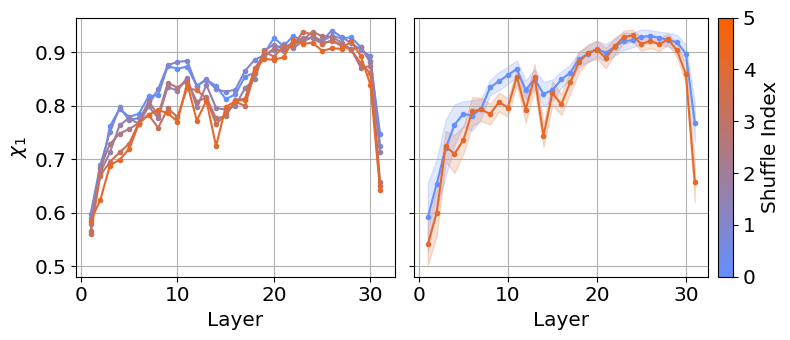

In [26]:
start_ind = 1
end_ind = num_layers 
xrange = np.arange(start_ind, end_ind)
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey="row")
model_name = "Llama-3-8B"
knn = 1
for jdx in range(2):
    ax = axes[jdx]
    ops = mnos[model_name][:, :, knn]
    if jdx == 0: ax.set_ylabel(f"$\chi_{{{knn}}}$", fontsize="x-large")
    if jdx == 0:
        for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * TEST_INDX_SHUFFLE, NUM_SHUFFLES * (TEST_INDX_SHUFFLE + 1))):
            ax.plot(xrange, ops[shuffle_idx], marker='.', c=cmap2(qdx/NUM_SHUFFLES))
    else:
        for qdx in [0, 5]:
            op = ops[qdx::6, :]

            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label=model_name, c=cmap2(qdx/NUM_SHUFFLES), marker='.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmap2(qdx/NUM_SHUFFLES), alpha=0.2)

    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

# Create a ScalarMappable object for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=NUM_SHUFFLES-1))
sm.set_array([])

# Add color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Shuffle Index', fontsize='x-large')
cbar.ax.tick_params(labelsize='x-large')

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
plt.savefig(f'figs/shuffle/mno_{knn}_llama_{TEST_INDX_SHUFFLE}.png', bbox_inches='tight', dpi=300)
plt.show()

## Appendix

### ID profiles for 6 random shuffles

/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_4539/942591548.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


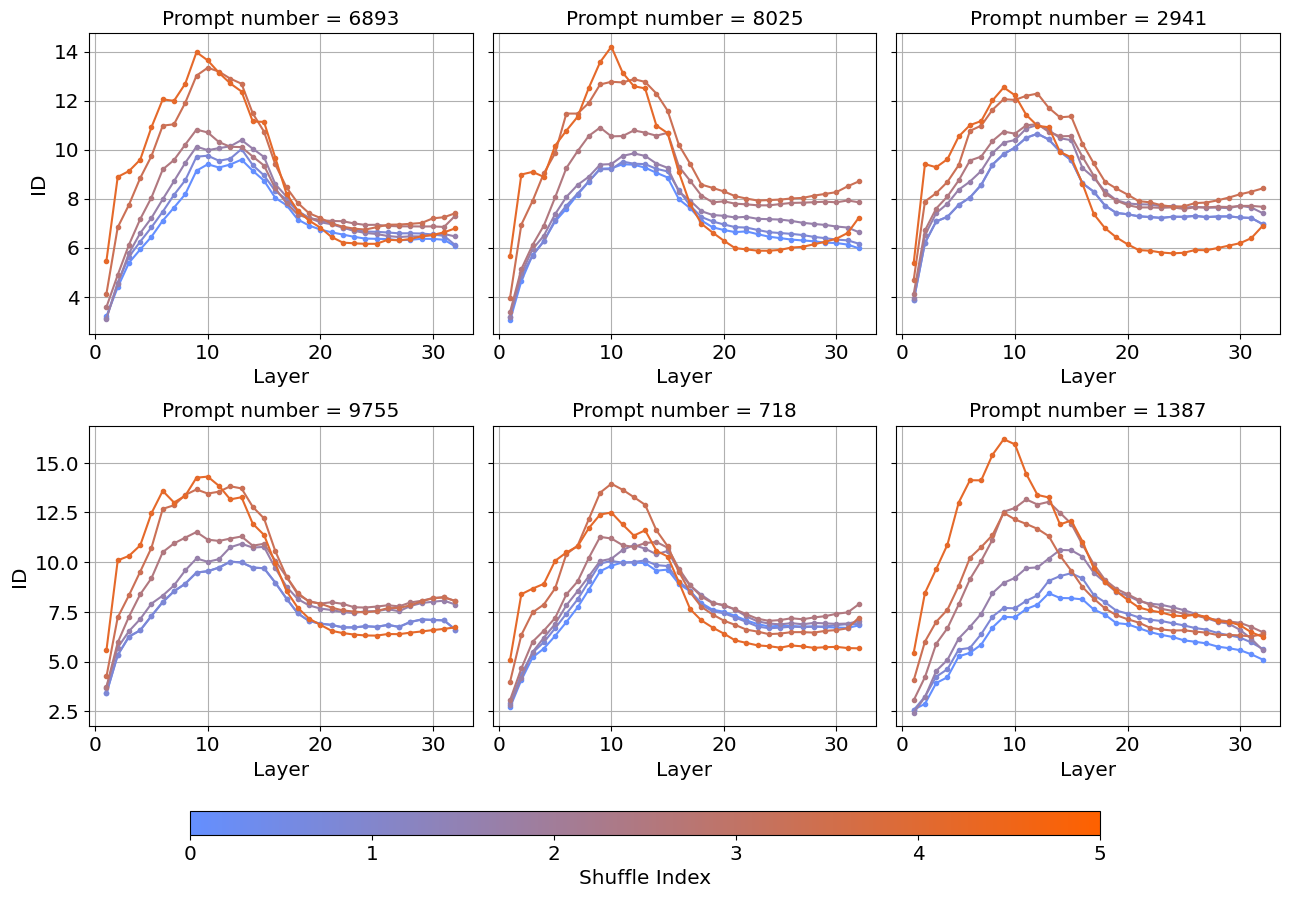

In [29]:
start_ind = 1
end_ind = num_layers + 1
xrange = np.arange(start_ind, end_ind)
fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey="row")
rs_idx = 0
model_name = "Llama-3-8B"

all_indices = np.random.choice(50, 10, replace=False)
for jdx in range(6):
    tindx = all_indices[jdx]
    ax = axes[jdx // 3][jdx % 3]
    ops = ids[model_name][:, :, rs_idx]
    if jdx % 3 == 0: 
        ax.set_ylabel(f"ID", fontsize="x-large")
    
    for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * tindx, NUM_SHUFFLES * (tindx + 1))):
        ax.plot(xrange, ops[shuffle_idx], marker='.', c=cmap2(qdx / NUM_SHUFFLES))
    ax.set_title(f"Prompt number = {subset_indices[tindx]}", fontsize = "x-large")
    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

# Create a ScalarMappable object for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=NUM_SHUFFLES - 1))
sm.set_array([])

# Add color bar below the figure
cax = fig.add_axes([0.15, -0.05, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Shuffle Index', fontsize='x-large')
cbar.ax.tick_params(labelsize='x-large')
plt.tight_layout()
plt.savefig(f'figs/shuffle/appendix/6_random_prompts.png', bbox_inches='tight', dpi=300)
plt.show()

### All models

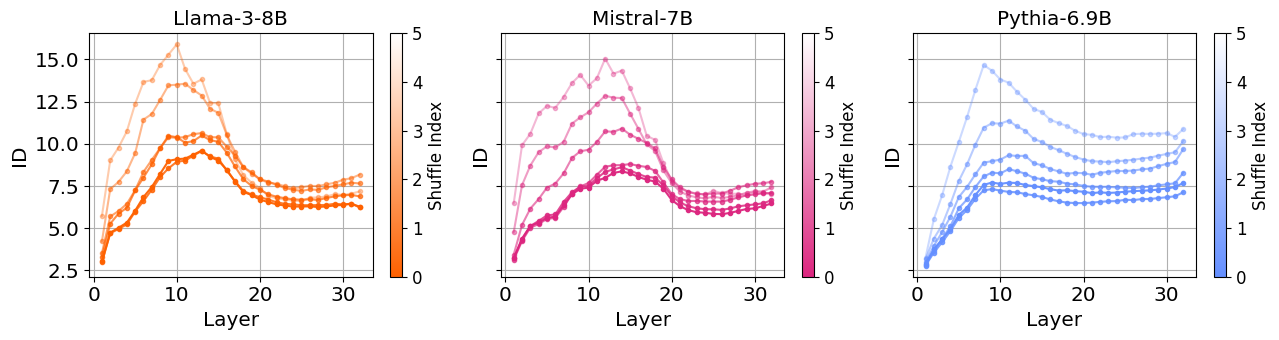

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all necessary variables (num_layers, ids, all_models, model_titles, cmp, NUM_SHUFFLES, TEST_INDX) are defined

start_ind = 1
end_ind = num_layers + 1
xrange = np.arange(start_ind, end_ind)

fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey="row")
rs_idx = 0

 
norm = plt.Normalize(0, NUM_SHUFFLES - 1)  # Normalize alpha values for color mapping

for jdx, model_name in enumerate(all_models):
    ax = axes[jdx]
    
    positions = [0, 1]
    colors = [cmp[model_name], 'white']
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))
    op = ids[model_name][:, :, rs_idx]
    ax.set_title(f'{model_name}', fontsize="x-large")
    ax.set_ylabel(f"ID", fontsize="x-large")

    for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * TEST_INDX_SHUFFLE, NUM_SHUFFLES * (TEST_INDX_SHUFFLE + 1))):
        baseline = 2
        alpha = 1.2 - (baseline + qdx) / (NUM_SHUFFLES + baseline)
        label = model_titles[model_name] if qdx == 0 else None 
        ax.plot(xrange, op[shuffle_idx], marker='.', c=cmp[model_name], alpha= alpha, label=label)

    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

    # Create a colorbar for each subplot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Shuffle Index', fontsize='large')
    cbar.ax.tick_params(labelsize='large')

plt.tight_layout()
plt.savefig(f'figs/shuffle/appendix/all_models_{TEST_INDX_SHUFFLE}.png', bbox_inches='tight')
plt.show()

### Neighborhood overlap for knn = 2 and 4

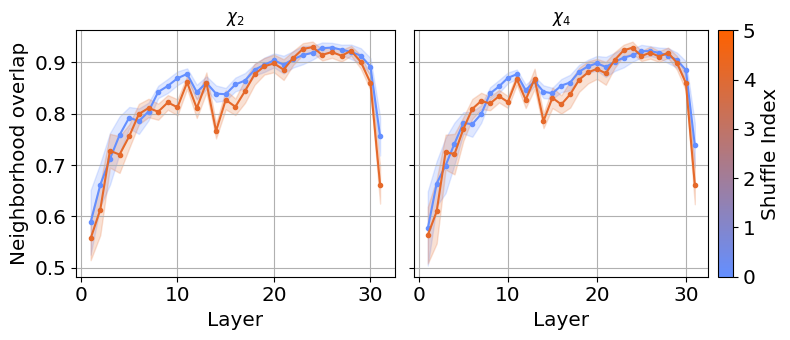

In [32]:
start_ind = 1
end_ind = num_layers 
xrange = np.arange(start_ind, end_ind)
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey="row")
model_name = "Llama-3-8B"
for jdx in range(2):
    knn = 2*2**jdx
    ax = axes[jdx]
    ops = mnos[model_name][:, :, knn]
    if jdx == 0:ax.set_ylabel("Neighborhood overlap", fontsize="x-large")
    # if jdx == 0:
    #     for qdx, shuffle_idx in enumerate(range(NUM_SHUFFLES * TEST_INDX, NUM_SHUFFLES * (TEST_INDX + 1))):
    #         ax.plot(xrange, ops[shuffle_idx], marker='.', c=cmap2(qdx/NUM_SHUFFLES))
    # else:
    for qdx in [0, 5]:
        op = ops[qdx::6, :]

        # Calculate mean and standard deviation
        mean_op = op.mean(axis=0)
        std_op = op.std(axis=0)

        # Plot the mean curve
        ax.plot(xrange, mean_op, label=model_name, c=cmap2(qdx/NUM_SHUFFLES), marker='.')

        # Fill between the mean +/- std (shaded area)
        ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmap2(qdx/NUM_SHUFFLES), alpha=0.2)
    ax.set_title(f"$\chi_{{{knn}}}$")
    ax.set_xlabel("Layer", fontsize="x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

# Create a ScalarMappable object for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=NUM_SHUFFLES-1))
sm.set_array([])

# Add color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Shuffle Index', fontsize='x-large')
cbar.ax.tick_params(labelsize='x-large')

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
plt.savefig(f'figs/shuffle/appendix/no_2_4.png', bbox_inches='tight', dpi=300)
plt.show()